In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
import operator
from typing import Literal
from langchain_core.messages import SystemMessage, HumanMessage

In [2]:
Api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key= Api_key
)

In [3]:
generator_model = model
evalutor_model = model
optimizer_model = model

In [4]:
class StructuredEvalution(BaseModel):
    evalution : Literal["approved","need_optimization"] = Field (..., description="final evalution")
    feedback : str = Field(..., description="feedback for the tweet...")


In [5]:
structured_Evaluatior  = evalutor_model.with_structured_output(StructuredEvalution)

In [6]:
class X_post(TypedDict):
    topic : str
    tweet : str
    evalution : Literal["approved","needs_improvement"]
    feedback : str
    iteration: int
    max_iterations: int 



In [7]:
def generate_post(state: X_post) -> dict:
    prompt = [
        SystemMessage(content = "You are a social media content generator and have experience in posting engaging tweets."),
        HumanMessage(content = f"""Create an engaging tweet about the following topic: {state['topic']}
        Rules:
                     - The tweet should be concise and attention-grabbing.
                     - Use relevant hashtags to increase visibility.
                     - Ensure the tweet is appropriate for a wide audience.
                     - This is the version {state['iteration'] + 1} of the tweet.
                     Provide only the tweet content without any additional commentary.
                     - Use a maximum of 280 characters.
                     - Use Simple language that is easy to understand.
                     - Avoid using jargon or complex terms.
                     - Tweet must be funny and witty."""),
    ]
    response = generator_model.invoke(prompt).content
    return {
        "tweet": response
    }

In [8]:
def evaluate_post(state : X_post) -> dict :
    prompt = [
        SystemMessage(content="You are a ruthless , no laugh Twitter critic . You Evaluate Tweets based on humer originality , virality , and tweet format "),
        HumanMessage(content=f"""
        Evaluate the following tweet :
                    Tweet : '{state['tweet']}'


---

**Use the criteria below to evaluate the tweet:**

1. **Originality** – Is it fresh, or something you’ve seen many times before?
2. **Humor** – Does it genuinely make you smile, laugh, or chuckle?
3. **Punchiness** – Is it short, sharp, and scroll-stopping?
4. **Virality Potential** – Would people realistically retweet or share it?
5. **Format** – Is it a well-formed tweet (under 280 characters, not a setup-punchline joke, not a Q&A joke)?

Auto-reject if:

* It is written in question-answer format (e.g., “Why did…” or “What happens when…”)
* It exceeds 280 characters
* It reads like a traditional setup-punchline joke
* It ends with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces…”)

**Respond ONLY in the following structured format:**


evaluation: "approved" or "needs_improvement"
feedback: One paragraph explaining the strengths and weaknesses

""")
    ]

    response = structured_Evaluatior.invoke(prompt)
    return {
        "evalution" : response.evalution,
        "feedback" : response.feedback
    }

In [9]:
def optimize_post(state : X_post) -> dict:
    messages = [
SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"
Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}
Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response = optimizer_model.invoke(messages).content
    iteration = state["iteration"] + 1

    return {
        "tweet" : response ,
        "iteration" : iteration
    }



In [10]:
def route_evalution(state : X_post):
    if state["evalution"] == "approved" or state["iteration"] >= state["max_iterations"]:
        return "approved"
    else :
        return "needs_improvement"

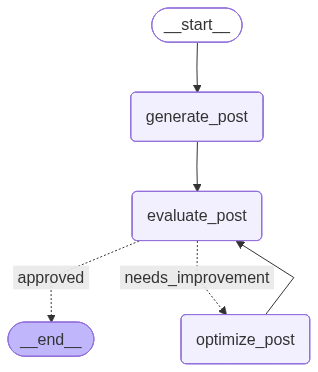

In [11]:
graph = StateGraph(X_post)

graph.add_node("generate_post",generate_post)
graph.add_node("evaluate_post",evaluate_post)
graph.add_node("optimize_post",optimize_post)   


graph.add_edge(START , "generate_post")
graph.add_edge("generate_post","evaluate_post")

graph.add_conditional_edges("evaluate_post",route_evalution ,{"approved" : END, "needs_improvement" : "optimize_post"})
graph.add_edge("optimize_post","evaluate_post")

workflow = graph.compile()
workflow


In [12]:
initial_state = {
    "topic" : "Jobloss due to AI",
    "iteration" : 1,
    "max_iterations" : 5
}

response = workflow.invoke(initial_state)
response 

{'topic': 'Jobloss due to AI',
 'tweet': 'Just got laid off—turns out my job was outsourced to a robot that doesn’t even need coffee breaks. If AI can do my job and my laundry, I’m officially ready for retirement... or at least a couch potato career. 😂🤖 #ThanksAI #LivingTheDream',
 'evalution': 'approved',
 'feedback': "This tweet offers a clever twist on the common theme of job automation by introducing a humorous take on being replaced by a robot. The humor is relatable and showcases a fresh perspective on AI's impact on employment with a light-hearted angle. It's well-formatted, under the character limit, and avoids traditional punchline setups. The use of emojis adds to its appeal and enhances engagement, making it more likely to be shared and retweeted. Overall, it's a concise, witty commentary on modern working life.",
 'iteration': 2,
 'max_iterations': 5}